<a href="https://colab.research.google.com/github/RiadMhajne/HandDrawnShapesAI/blob/main/DetectAndRedrawShapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **First moudel**
classfy the drawn shape

# **prepare the data**

In [ ]:
! unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/user.u14/images/other/other.u14.0091.png  
  inflating: data/user.u14/images/other/other.u14.0092.png  
  inflating: data/user.u14/images/other/other.u14.0093.png  
  inflating: data/user.u14/images/other/other.u14.0094.png  
  inflating: data/user.u14/images/other/other.u14.0095.png  
  inflating: data/user.u14/images/other/other.u14.0096.png  
  inflating: data/user.u14/images/other/other.u14.0097.png  
  inflating: data/user.u14/images/other/other.u14.0098.png  
  inflating: data/user.u14/images/other/other.u14.0099.png  
  inflating: data/user.u14/images/other/other.u14.0100.png  
  inflating: data/user.u14/images/other/other.u14.0101.png  
  inflating: data/user.u14/images/other/other.u14.0102.png  
  inflating: data/user.u14/images/other/other.u14.0103.png  
  inflating: data/user.u14/images/other/other.u14.0104.png  
  inflating: data/user.u14/images/other/other.u14.0105.png  
  inflating: data/user.u14/images/

In [ ]:
import imageio
import numpy as np
import os
from pathlib import Path
from six.moves import cPickle as pickle
import ntpath
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model   
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from shapely.geometry import Polygon
from scipy import ndimage
from skimage.transform import resize
from tensorflow.keras.utils import Sequence
seed1 = 129
np.random.seed(seed1)


In [ ]:
DATA_DIR = "/content/data"
MODEL_DIR  = "/content/model"
model_name = os.path.join(MODEL_DIR, "my_model") 

In [ ]:
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

In [ ]:
validation_users = ['crt', 'il1', 'lts', 'mrt', 'nae']
test_users =  ['u01', 'u17', 'u18', 'u19']

In [ ]:
image_size  = 70 # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [ ]:
output_labels = [
  
  
  'rectangle', #    0
  'triangle',#    1
  'other']  #    2

num_classes = len(output_labels)

In [ ]:
def get_label_for_shape(shape_dir):
    shape = os.path.basename(shape_dir)
    #from the data we want to calssify only rectangles and triangles
    if shape == "rectangle":
        return 0
    elif shape == "triangle":
        return 1
    elif shape =="ellipse": #drop the ellipse sampels to make an equal number of sampels for evry label 
        return -1
    else:
        return 2

In [ ]:
def get_dir_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, n))]

def get_file_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isfile(os.path.join(root, n))]

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

In [ ]:
def normalize_image(image_file, pixel_depth):
    """
    Normalize image by pixel depth by making it white on black instead of black on white
    """
    try:
        array = imageio.imread(image_file)
    except ValueError:
        raise

    return 1.0 - (array.astype(float))/pixel_depth  # (1 - x) will make it white on black

In [ ]:
def load_images_for_shape1(shape_directory, pixel_depth, 
                          user_images, user_images_labels,
                          shape_label, verbose=False, min_nimages=1):
    """
    Load all images for a specific user and shape into user_images.
    Labels are put in user_images_labels
    """  
    
    if verbose:
        print("directory for load_images_for_shapes: ", shape_directory)

    image_files = get_file_paths(shape_directory)
    image_index = 0

    for image_file in image_files:
        try:
            if path_leaf(image_file).startswith('.'):  # skip files like .DSStore
                continue

            image_data_all_channels = normalize_image(image_file, pixel_depth)
            image_data = image_data_all_channels[:, :, 0]

            user_images.append(image_data)
            user_images_labels.append(shape_label)
            image_index += 1
        except Exception as error:
            print(error)
            print('Skipping because of not being able to read: ', image_file)

    if image_index < min_nimages:
        raise Exception(f'Fewer images than expected: {image_index} < {min_nimages}')

In [ ]:
def load_images_for_user1(user_directory, pixel_depth,
                         user_images, user_images_labels,
                         verbose=False):
    """
    Load all images for a specific user
    """      
    
    images_dir = os.path.join(user_directory, "images")

    if verbose:
        print("directory for load_images_for_shapes: ", images_dir)

    shape_dirs = get_dir_paths(images_dir)
    for dir in shape_dirs:
        label = get_label_for_shape(dir)
        if label >= 0:
            load_images_for_shape1(dir, pixel_depth, user_images, user_images_labels, label)
def plot_sample(image, axs):
    axs.imshow(image.reshape(image_size, image_size), cmap="gray")

In [ ]:
data_paths = get_dir_paths(DATA_DIR)
print(f"Dataset contains 1 directory per user:")
data_paths

Dataset contains 1 directory per user:


['/content/data/user.aly',
 '/content/data/user.crt',
 '/content/data/user.drt',
 '/content/data/user.elu',
 '/content/data/user.frt',
 '/content/data/user.if1',
 '/content/data/user.if2',
 '/content/data/user.if3',
 '/content/data/user.if5',
 '/content/data/user.if8',
 '/content/data/user.il1',
 '/content/data/user.ilb',
 '/content/data/user.im1',
 '/content/data/user.lrt',
 '/content/data/user.lt1',
 '/content/data/user.lts',
 '/content/data/user.mrt',
 '/content/data/user.nae',
 '/content/data/user.nld',
 '/content/data/user.u01',
 '/content/data/user.u02',
 '/content/data/user.u03',
 '/content/data/user.u04',
 '/content/data/user.u05',
 '/content/data/user.u06',
 '/content/data/user.u07',
 '/content/data/user.u08',
 '/content/data/user.u09',
 '/content/data/user.u10',
 '/content/data/user.u11',
 '/content/data/user.u12',
 '/content/data/user.u13',
 '/content/data/user.u14',
 '/content/data/user.u17',
 '/content/data/user.u18',
 '/content/data/user.u19',
 '/content/data/user.vly']

In [ ]:
train_user_images = []
train_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:] # User unique id is the last 3 letters
    if user_id not in validation_users and user_id not in test_users:
        load_images_for_user1(user_dir, pixel_depth, train_user_images, train_user_images_label)

train_data = np.array(train_user_images)
train_labels = np.array(train_user_images_label)

print('train_data shape: ', train_data.shape)
print('train_labels shape: ', train_labels.shape)

unique, counts = np.unique(train_labels, return_counts=True)
print("train label dist.: ", dict(zip(unique, counts)))

train_data shape:  (16361, 70, 70)
train_labels shape:  (16361,)
train label dist.:  {0: 5737, 1: 5308, 2: 5316}


In [ ]:
val_user_images = []
val_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:] # User unique id is the last 3 letters
    if user_id in validation_users:    
        load_images_for_user1(user_dir, pixel_depth, val_user_images, val_user_images_label)

val_data = np.array(val_user_images)
val_labels = np.array(val_user_images_label)

print('val_data shape: ', val_data.shape)
print('val_labels shape: ', val_labels.shape)
unique, counts = np.unique(val_labels, return_counts=True)
print("val label dist.: ", dict(zip(unique, counts)))

val_data shape:  (2914, 70, 70)
val_labels shape:  (2914,)
val label dist.:  {0: 860, 1: 924, 2: 1130}


In [ ]:
test_user_images = []
test_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:] # User unique id is the last 3 letters
    if user_id in test_users:  
        load_images_for_user1(user_dir, pixel_depth, test_user_images, test_user_images_label)

test_data   = np.array(test_user_images)
test_labels = np.array(test_user_images_label)

print('test_data shape: ', test_data.shape)
print('test_labels shape: ', test_labels.shape)
unique, counts = np.unique(test_labels, return_counts=True)
print("test label dist.: ", dict(zip(unique, counts)))

test_data shape:  (1563, 70, 70)
test_labels shape:  (1563,)
test label dist.:  {0: 359, 1: 363, 2: 841}


# **define and train the model**

In [ ]:
train_X = train_data
train_y = train_labels

In [ ]:
val_X = val_data
val_y = val_labels

In [ ]:
X_train = train_X.reshape(-1, image_size, image_size, 1)
X_val   = val_X.reshape(-1, image_size, image_size, 1)

In [ ]:
Y_train = to_categorical(train_y, num_classes = num_classes)
Y_val   = to_categorical(val_y, num_classes = num_classes)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def get_model_cnn1():
    # Set the CNN model using Keras functional API
    input_img = Input(shape=(image_size,image_size,1))

    x = Conv2D(32, (5, 5), padding='same')(input_img)  # Conv2D 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (5, 5), padding='same')(x)          # Conv2D 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3))(x)                          # Conv2D 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3))(x)                          # Conv2D 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3))(x)                         # Conv2D 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)                         # Conv2D 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x) 

    x = Flatten()(x)
    x = Dense(200)(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=output)
    
    return model

In [ ]:
model = get_model_cnn1()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 70, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 70, 70, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 70, 70, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 70, 70, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 32)        25632 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=180,                  # Randomly rotate images in the range (degrees, 0 to +/-180)
#         zoom_range = [0.98, 1.02],         # Randomly zoom image a bit. Not required
        horizontal_flip=True,                # Randomly horizontal flip 
        vertical_flip=True)  

In [ ]:
optimizer = Adam(learning_rate=2e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08,  amsgrad=False)

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Keras callback to show the result of the best epoch in the model
# Intended to work with ModelCheckpoint callback.
class ShowBestEpochResult(tf.keras.callbacks.Callback):
    def __init__(self, on_param='val_loss', show_params=['val_loss', 'loss'], mode='min'):
        self.on_param    = on_param
        self.show_params = show_params
        self.mode        = mode

    def on_train_begin(self, logs=None):
        # The number of epoch at which the best value is found.
        self.best_epoch = 0

        # The best value found for the on_param.
        self.best = np.Inf
        if self.mode == 'max':
            self.best = np.NINF
            
        # The values on best epoch for each param in show_param.
        self.best_values = {}

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.on_param)
        save_as_best = (self.mode=='min' and current < self.best) or \
                       (self.mode=='max' and current > self.best)

        if save_as_best: 
            self.best = current
            for param in self.show_params:
                self.best_values[param] = logs.get(param)
            self.best_epoch = epoch

    def on_train_end(self, logs=None):
        print(f"BestEpochResult. Epoch: {self.best_epoch+1},", end=" ")

        for param in self.best_values:
            print(f"{param}: {self.best_values[param]:.5f},", end=" ")
        print(" ")

In [ ]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=15,
                                            verbose=1,
                                            factor=0.9,
                                            min_lr=0.000000001)


In [ ]:
# Train and Save the Best model

h5_path    = model_name + ".h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

best_epoch_results = ShowBestEpochResult(on_param='val_accuracy', show_params=['val_accuracy', 'accuracy', 'val_loss', 'loss'], mode='max')

callbacks_list = [learning_rate_reduction, checkpoint, best_epoch_results]


epochs = 20
batch_size = 64
zz=datagen.flow(X_train,Y_train, batch_size=batch_size, seed=seed1)
history = model.fit(zz,
                              epochs=epochs, validation_data=(X_val,Y_val),
                              verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=callbacks_list)

In [ ]:
# Delete the existing model
del model

# Load last saved model
model = load_model(model_name + ".h5")
print(model_name)

/content/model/my_model


In [ ]:
## Prepare test set
test_X = test_data
test_y = test_labels
print("test_X shape: ", test_X.shape)
print("test_y shape: ", test_y.shape)

X_test = test_X.reshape(-1, image_size, image_size, 1)
Y_test = to_categorical(test_y, num_classes=num_classes)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

test_X shape:  (1563, 70, 70)
test_y shape:  (1563,)
X_test shape:  (1563, 70, 70, 1)
Y_test shape:  (1563, 3)


In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("test_acc: ", test_acc)

49/49 [==============================] - 1s 9ms/step - loss: 0.0168 - accuracy: 0.9949
test_acc:  0.9948816299438477


# **try the first model ourselves**

In [ ]:
def prepare(filepath):
  image_data_all_channels = normalize_image(filepath, 255)
  
  image_data = 1-image_data_all_channels[:, :, 3]
  return image_data.reshape(-1,700,700,1)


In [ ]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=700, h=700, line_width=1):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  aaaaa =cv2.imread("/content/1.png",-1)
  print(aaaaa.shape)
  aaq=cv2.resize(aaaaa, (70,70))
  x=prepare("/content/1.png")
  plt.imshow(aaq)
  plt.axis("off")
  plt.show()
  aaq = aaq[:,:,3]
  im = aaq.reshape(-1,70,70,1)/255
  pred = model.predict([im])
  return output_labels[pred.argmax()],aaaaa

(700, 700, 4)


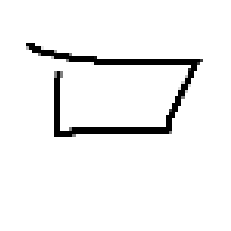

1/1 [==============================] - 0s 181ms/step


'rectangle'

In [ ]:
name,arr = draw("1.png",line_width=20)
name

# **second model**
detect the shapes(rectangle) edges

# **prepare the data**

In [ ]:
def is_correct_shape_to_process(shapeDir, correct_shape):
    shape = os.path.basename(shapeDir)
    if shape == correct_shape:
        return True
    return False

In [ ]:
def select_first_vertice_index(vertices, vertice_count, x_pos, y_pos):
    """
    The first vertex will be the vertex that is closest to the anchor point
    specified as (x_pos, y_pos)
    """
    nearest_index = find_nearest_index(vertices, x_pos, y_pos, vertice_count)

    return nearest_index

In [ ]:
def find_nearest_index(vertices, x_from, y_from, vertice_count):
    """
    Find the index of the vertex that is the closest to specified 
    coordinate (x_from, y_from).
    """

    min_distance_squared  = 1000000
    nearest_index = 0

    x_from *= 1000
    y_from *= 1000

    for index, vertice in enumerate(vertices):
        dx = (vertice[0] * 1000) - x_from
        dy = (vertice[1] * 1000) - y_from
        square_dist = dx*dx + dy*dy
        
        if square_dist < min_distance_squared and index < vertice_count:
            nearest_index = index
            min_distance_squared = square_dist

    return nearest_index

In [ ]:
def sort_vertices_clockwize(vertices, first_vertice_index, vertice_count):
    """
    Sort the vertices by navigating clockwise starting with the first vertex
    """
    vertices_sorted = np.zeros(vertices.shape)

    first_vertice_angle = 0
    smaller_vertices = []   # contains an aray of tuple (index, angle) where the angle is smaller to the 1st vertice
    bigger_vertices  = []   # contains an aray of tuple (index, angle) where the angle is bigger  to the 1st vertice
    for index, vertice in enumerate(vertices):
        if index < vertice_count:
            vertice_angle = np.arctan2(0.5 - vertice[1], vertice[0] - 0.5) * 180 / np.pi
            if vertice_angle < 0:
                vertice_angle = 360 + vertice_angle
            if index == first_vertice_index:
                first_vertice_angle = vertice_angle
                break

    for index, vertice in enumerate(vertices):
        if index < vertice_count:
            vertice_angle = np.arctan2(0.5 - vertice[1], vertice[0] - 0.5) * 180 / np.pi
            if vertice_angle < 0:
                vertice_angle = 360 + vertice_angle
            if index != first_vertice_index:
                if vertice_angle < first_vertice_angle:
                    smaller_vertices.append((index, vertice_angle))
                else:
                    bigger_vertices.append((index, vertice_angle))

    # Ordered (clockwise) vertices that we need will be composed of:
    # 1. The first vertice
    # 2. The smaller vertice from the biggest angle to the smallest angle (0)
    # 2. The bigger  vertice from the biggest angle to the smallest angle (first_vertice_angle)
    vertices_ordered = [vertices[first_vertice_index]]
    smaller_vertices.sort(key=lambda x: x[1], reverse=True)
    bigger_vertices.sort( key=lambda x: x[1], reverse=True)
    for index, vertice_angle in smaller_vertices:
        vertices_ordered.append(vertices[index])
    for index, vertice_angle in bigger_vertices:
        vertices_ordered.append(vertices[index])

    for i in range(0, vertice_count):
        vertices_sorted[i] = vertices_ordered[i]
    return vertices_sorted

In [ ]:
def load_images_for_shape(shape_directory, pixel_depth, user_images,
                          user_images_labels, user_images_paths, 
                          min_nimages=1, 
                          vertice_count=4, 
                          x_pos=0.2, y_pos=1.0,
                          verbose=False):
    """
    Load images and vertices for a specific user and shape.
    """

    if verbose:
        print("directory for load_images_for_shape: ", shape_directory)

    image_files = get_file_paths(shape_directory)
    image_index = 0

    for image_file in image_files:
        try:
            if path_leaf(image_file).startswith('.'):  # skip files like .DSStore
                continue

            # Make sure that the corresponding vertice file exists
            vertice_file = replace_last(image_file, "/images/", "/vertices/")
            vertice_file = replace_last(vertice_file, ".png", ".csv")

            if os.path.exists(vertice_file) == False:
                raise FileNotFoundError(vertice_file)

            # Load Vertices file as points
            vertices = np.loadtxt(vertice_file, delimiter=",") #, max_rows=3)

            # Re-order the vertices. Start by finding the first vertex.
            first_vertice_index = select_first_vertice_index(vertices, vertice_count=vertice_count, x_pos=x_pos, y_pos=y_pos)
            vertices_sorted     = sort_vertices_clockwize(vertices, first_vertice_index=first_vertice_index, vertice_count=vertice_count)

            vertices = vertices_sorted.ravel()
            vertices = vertices.reshape(-1)
            vertices = vertices[:vertice_count*2] # *2 because x and y are separate

            image_data_all_channels = normalize_image(image_file, pixel_depth)
            image_data = image_data_all_channels[:, :, 0]

            user_images.append(image_data)
            user_images_labels.append(vertices)

            image_index += 1
        except Exception as error:
            print(error)
            print('Skipping because of not being able to read: ', image_file)

    if image_index < min_nimages:
        raise Exception('Fewer images than expected: %d < %d' % (image_index, min_nimages))

verbose = False  # Set to True to get more output

In [ ]:
shape = "rectangle"
nb_vertices = 4

anchor_x = 0.2
anchor_y = 1.0

In [ ]:
BASEDIR = "/content"

DATA_DIR        = os.path.join(BASEDIR, "data")


In [ ]:
validation_users = ['drt', 'il1', 'lt1', 'lts', 'u01', 'u04', 'u04', 'u05', 'u08', 'u09', 'u10', 'u12', 'u17']
test_users = ['u18', 'u19']

In [ ]:
data_paths = get_dir_paths(DATA_DIR)


In [ ]:
def load_images_for_user(user_root, pixel_depth,
                         user_images, user_images_labels,
                         user_images_paths, verbose=False):
    """
    Load all images and vertices for a specific user and shape
    """  
    images_dir = os.path.join(user_root, "images")

    if verbose:
        print("root for load_images_for_user: ", images_dir)

    shape_dirs = get_dir_paths(images_dir)
    for dir in shape_dirs:
        if is_correct_shape_to_process(dir, shape):
            load_images_for_shape(dir, pixel_depth, user_images, user_images_labels, user_images_paths, \
                                  vertice_count=nb_vertices, x_pos=anchor_x, y_pos=anchor_y, verbose=verbose)

In [ ]:
def replace_last(source_string, replace_what, replace_with):
    head, _sep, tail = source_string.rpartition(replace_what)
    return head + replace_with + tail

In [ ]:
train_user_images = []
train_user_images_labels = []
train_user_images_paths = {}

for user_dir in data_paths:
    user_id = user_dir[-3:]  # User unique id is the last 3 letters
    if user_id not in validation_users and user_id not in test_users:
        load_images_for_user(user_dir, pixel_depth, train_user_images, train_user_images_labels, \
                             train_user_images_paths, verbose=verbose)

train_data   = np.array(train_user_images)
train_labels = np.array(train_user_images_labels)

print('train_data shape: ', train_data.shape)
print('train_labels shape: ', train_labels.shape)

if verbose:
    # Show distribution of the x,y for all vertices 
    unique, counts = np.unique(train_labels, return_counts=True)
    print("train label dist.: ", dict(zip(unique, counts)))



train_data shape:  (5386, 70, 70)
train_labels shape:  (5386, 8)


In [ ]:
val_user_images = []
val_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:]  # User unique id is the last 3 letters
    if user_id in validation_users:
        load_images_for_user(user_dir, pixel_depth, val_user_images, val_user_images_label, \
                             train_user_images_paths, verbose=verbose)

val_data = np.array(val_user_images)
val_labels = np.array(val_user_images_label)

print('val_data shape: ', val_data.shape)
print('val_labels shape: ', val_labels.shape)

if verbose:
    # Show distribution of the x,y for all vertices 
    unique, counts = np.unique(val_labels, return_counts=True)
    print("val label dist.: ", dict(zip(unique, counts)))



val_data shape:  (1391, 70, 70)
val_labels shape:  (1391, 8)


In [ ]:
test_user_images = []
test_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:]  # User unique id is the last 3 letters
    if user_id in test_users:
        load_images_for_user(user_dir, pixel_depth, test_user_images, test_user_images_label, \
                             train_user_images_paths, verbose=verbose)

test_data   = np.array(test_user_images)
test_labels = np.array(test_user_images_label)

print('test_data shape: ', test_data.shape)
print('test_labels shape: ', test_labels.shape)

if verbose:
    # Show distribution of the x,y for all vertices 
    unique, counts = np.unique(test_labels, return_counts=True)
    print("test label dist.: ", dict(zip(unique, counts)))



test_data shape:  (179, 70, 70)
test_labels shape:  (179, 8)


# **define and train the model**

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

import os
from pathlib import Path

from six.moves import cPickle as pickle

In [ ]:
# More packages
import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


import datetime
datetime.datetime.now()

datetime.datetime(2023, 3, 6, 10, 31, 48, 212025)

In [ ]:
def calculate_Dice(label, pred, nb_vertices=4):
    
    y_polygon   = Polygon(label.reshape(nb_vertices, 2))
    pred_polygon= Polygon(pred.reshape(nb_vertices, 2))

    I = y_polygon.intersection(pred_polygon).area
    U = y_polygon.union(pred_polygon).area
    dice = 2 * I / (y_polygon.area + pred_polygon.area) 
    return dice

In [ ]:
def calculate_Dice_for_set(Y, Y_pred, nb_vertices):

    nb_samples = Y.shape[0]
    dice_sum = 0.0
    valid_shapes_count = 0
    for i in range(nb_samples):
        try:
            dice = calculate_Dice(Y[i], Y_pred[i], nb_vertices=nb_vertices)
            dice_sum += dice
            valid_shapes_count += 1
        except Exception as e:
            print(f"Cannot compute Dice for shape: {i}.")    

    return dice_sum / valid_shapes_count


In [ ]:
def polar_to_cartesian(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


In [ ]:
class HdsDataGenerator(Sequence):
    """
    Generates data for Keras while modifying the labels
    as the images are flipped or rotated.
    """

    def __init__(self, list_IDs, x_set, y_set, batch_size=32, dim=(70, 70), n_channels=1, n_vertices=4, x_pos=0.0, y_pos=0.65, shuffle=True):
        """
        Initialization
        """
        self.dim = dim
        self.im_size = dim[0]
        self.batch_size = batch_size
        self.x_set = x_set
        self.y_set = y_set
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_vertices = n_vertices
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def rotate_vertices(self, label, angle, padding_is_used, padding):  
        """
        Rotate vertices counter-clockwize in degres
        """
        nb_label = len(label)
        label_new = np.array(label, copy=True)

        # rotate each point by angle
        vertices = label_new.reshape((-1, 2))

        for index, vertice in enumerate(vertices):
            x = vertice[0]
            y = vertice[1]

            dx = x - 0.5
            dy = y - 0.5
            current_angle  = np.arctan2(-dy, dx) * 180 / np.pi # Note Y is reversed
            current_length = np.sqrt(dx*dx + dy*dy)

            new_angle = current_angle + angle
            new_rad_angle = new_angle * np.pi / 180
            new_length = current_length
            if padding_is_used:
                new_length  *= (1 - 2*padding/self.im_size)

            new_dx, new_dy = polar_to_cartesian(new_length, new_rad_angle)

            new_x = 0.5 + new_dx
            new_y = 0.5 - new_dy  # Note Y is de-reversed
            label_new[2*index + 0] = new_x
            label_new[2*index + 1] = new_y

        return label_new

    def shift_vertices(self, label, offset_h_px, offset_v_px):

        label_new = np.array(label, copy=True)
        vertices = label_new.reshape((-1, 2))

        for index, vertice in enumerate(vertices):
            x = vertice[0]
            y = vertice[1]

            new_x = x + offset_h_px/self.im_size
            new_y = y + offset_v_px/self.im_size

            label_new[2*index + 0] = new_x
            label_new[2*index + 1] = new_y

        return label_new

    def get_margin_values(self, image_data):
        image_size = self.im_size

        # TODO Perform an analysis on the number of padding pixel.
        # All black on the left, top, right or bottom.
        # For each image Determine the smallest black margin

        im = image_data.reshape((image_size, image_size))

        mat_rows = np.all(im == 0, axis=1)
        mat_cols = np.all(im == 0, axis=0)

        rows = np.argwhere(mat_rows == False)
        cols = np.argwhere(mat_cols == False)
        top_margin = 0
        bottom_margin = 0
        left_margin = 0
        right_margin = 0

        if len(rows) > 0 and len(cols) > 0:
            top_margin = rows[0]
            bottom_margin = image_size - 1 - rows[-1]

            left_margin = cols[0]
            right_margin = image_size - 1 - cols[-1]

        return top_margin, right_margin, bottom_margin, left_margin

    def get_margin(self, image_data):
        top_margin, right_margin, bottom_margin, left_margin = self.get_margin_values(image_data)

        margin = [0]

        if top_margin != 0 or right_margin != 0 or bottom_margin != 0 or left_margin != 0:
            margin = min(top_margin + bottom_margin, left_margin + right_margin)

        return margin[0]

    def rotate_image(self, image, angle):
        rotated_image = ndimage.rotate(image, angle, reshape=False)
        cleaned_image = self.cleanup_image(rotated_image)
        return cleaned_image

    def center_image(self, image):
        top_margin, right_margin, bottom_margin, left_margin = self.get_margin_values(image)
        target_h_margin = (left_margin + right_margin) // 2
        target_v_margin = (top_margin + bottom_margin) // 2

        offset_h = target_h_margin - left_margin
        offset_v = target_v_margin - top_margin
        
        cleaned_image = image
        
        if offset_h != 0 or offset_v != 0:
            centered_image = ndimage.shift(image, (offset_v,offset_h))
            cleaned_image  = self.cleanup_image(centered_image)

        return cleaned_image, offset_h, offset_v

    def cleanup_image(self, image):
        img = image.reshape(self.dim)
        img[img > 1] = 1

        img[img < 0.1] = 0

        return img

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_vertices * 2))
        indices_lr = np.random.choice(1000, self.batch_size, replace=False)
        indices_ud = np.random.choice(1000, self.batch_size, replace=False)
        indices_ro = np.random.choice(380, self.batch_size, replace=False)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            image = np.array(self.x_set[ID], copy=True)
            label = np.array(self.y_set[ID], copy=True)

            is_modified = False

            # Perform modification on both X (the image) and y (the vertices)
            if (indices_lr[i] < 450):   # Flip Left - Right with probability 450/1000
                image = np.fliplr(image)
                for m in range(len(label)):
                    if m % 2 == 0:
                        label[m] = 1 - label[m]
                is_modified = True
            
            if (indices_ud[i] < 450):   # Flip Up - Down with probability 450/1000
                image = np.flipud(image)
                nb_label = len(label)
                for m in range(nb_label):
                    if m % 2 == 1:
                        label[m] = 1 - label[m]
                is_modified = True

            # Rotate counter-clockwize
            if indices_ro[i] < 360:     # Rotate with probability 360/380
                angle = indices_ro[i]

                margin_before = self.get_margin(image)

                image = self.rotate_image(image, angle)

                margin_rotated = self.get_margin(image)

                padding = int((margin_before - margin_rotated) / 2)
                padding_is_used = False

                image = image.reshape(self.dim)
                if margin_rotated < 10 and padding > 0:
                    image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant') 
                    image = resize(image, self.dim, anti_aliasing=True)
                    padding_is_used = True
                margin_padded = self.get_margin(image)

                label = self.rotate_vertices(label, angle, padding_is_used, padding)

                image, offset_h_px, offset_v_px = self.center_image(image)
                if offset_h_px != 0 or offset_v_px != 0:
                    label = self.shift_vertices(label, offset_h_px, offset_v_px)

                image = image.reshape((self.im_size, self.im_size, 1))

                is_modified = True

            if is_modified:
                # re-order the vertices in the labels
                vertices = label.reshape((self.n_vertices, 2))
                first_vertice_index = select_first_vertice_index(vertices, vertice_count=self.n_vertices, x_pos=self.x_pos, y_pos=self.y_pos)
                vertices_sorted = sort_vertices_clockwize(vertices, first_vertice_index=first_vertice_index,
                                                          vertice_count=self.n_vertices)
                label = vertices_sorted.reshape((self.n_vertices * 2,))

            X[i,] = image
            y[i] = label

        return X, y

In [ ]:
MODEL_DIR      = os.path.join("/content/working", "saved_models")
model_name     = os.path.join(MODEL_DIR, f"my_{shape}1.model")

In [ ]:
train_X = train_data
train_y = train_labels
val_X = val_data
val_y = val_labels

In [ ]:
# Reshape each image in 3 dimensions (height = 70px, width = 70px, canal = 1)
X_train = train_X.reshape(-1, image_size, image_size, 1)
X_val   = val_X.reshape(-1, image_size, image_size, 1)

In [ ]:
Y_train = train_y
Y_val = val_y

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def get_model_cnn():
    # Set the CNN model using Keras functional API
    input_img = Input(shape=(image_size, image_size, 1))

    x = Conv2D(32, (5, 5), padding='same')(input_img)  # Conv2D 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (5, 5), padding='same')(x)          # Conv2D 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3))(x)                          # Conv2D 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3))(x)                          # Conv2D 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3))(x)                         # Conv2D 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)                         # Conv2D 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.05)(x)

    x = Flatten()(x)
    x = Dense(200)(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output = Dense(nb_vertices * 2)(x)

    model = Model(inputs=input_img, outputs=output)
    
    return model

In [ ]:
# select a model
model = get_model_cnn()

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 70, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 70, 70, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 70, 70, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 70, 70, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 32)        25632 

In [ ]:
# Partition for the Generator
partition = []

nb_samples = X_train.shape[0]
print("nb_samples: ", nb_samples)

for i in range(nb_samples):
    partition.append(i)

nb_samples:  5386


In [ ]:
batch_size = 128
hds_gen = HdsDataGenerator(partition, X_train, Y_train, batch_size=batch_size,
                           n_vertices=nb_vertices,
                           x_pos=anchor_x,
                           y_pos=anchor_y)

In [ ]:
optimizer = Adam(learning_rate=2e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08,  amsgrad=False)

In [ ]:
model.compile(optimizer = optimizer , loss = "mean_squared_error")

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=25,
                                            verbose=1,
                                            factor=0.90, 
                                            mode='min',
                                            min_delta=0.0000001,
                                            min_lr=0.000000001)

In [ ]:
# Fit and Save the Best model
h5_path    = model_name + ".h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_loss', verbose=1, save_best_only=True)

best_epoch_results = ShowBestEpochResult(on_param='val_loss', show_params=['val_loss', 'loss'], mode='min')

callbacks_list = [learning_rate_reduction, checkpoint, best_epoch_results]

epochs  = 40 #1000
history = model.fit(x=hds_gen,
                      epochs=epochs, validation_data=(X_val, Y_val),
                      verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                      callbacks=callbacks_list)

In [ ]:
# deletes the existing model
model = 5
del model

# Load last saved model
model = load_model(model_name + ".h5")

In [ ]:
# Predict for the whole Validation set
Y_val_pred = model.predict(X_val)

44/44 [==============================] - 0s 4ms/step


In [ ]:
# Labels are vertices: x1, y1, x2, y2, x3, y3, y4, y4
# Where:
# - (0, 0) is the top left corner of the image
# - (1, 1) is the bottom right corner of the image
print("Y_val shape: ", Y_val.shape)
print("Y_val_pred shape: ", Y_val_pred.shape)
print("Real Label example: ", Y_val[0])
print("Prediction example: ", Y_val_pred[0])

Y_val shape:  (1391, 8)
Y_val_pred shape:  (1391, 8)
Real Label example:  [0.28 0.87 0.27 0.13 0.77 0.12 0.78 0.88]
Prediction example:  [0.2689895  0.83046776 0.24880582 0.14224294 0.7484805  0.12039395
 0.7661359  0.85370004]


In [ ]:
dice_val = calculate_Dice_for_set(Y_val, Y_val_pred, nb_vertices)
print(f"Validation Accuracy(Dice): {dice_val}.")

Cannot compute Dice for shape: 376.
Validation Accuracy(Dice): 0.9068607885714792.


In [ ]:
## Prepare the Test set

print("test_X shape: ", test_X.shape)
print("test_y shape: ", test_y.shape)

X_test    = test_X.reshape(-1, image_size,image_size, 1)
Y_test    = test_y 
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

test_X shape:  (1563, 70, 70)
test_y shape:  (1563,)
X_test shape:  (1563, 70, 70, 1)
Y_test shape:  (1563,)


In [ ]:
test_loss = model.evaluate(X_test, Y_test)
print("test_loss: ", test_loss)

49/49 [==============================] - 1s 6ms/step - loss: 1.3971
test_loss:  1.3970526456832886


# **visualization**

In [ ]:
def plot_sample_with_pred(X, y, pred,axs):
    axs.imshow(X.reshape(image_size, image_size),cmap="gray") # Shape
    axs.scatter(image_size*y[0::2], image_size*y[1::2],c='orange') # Real Vertices
    axs.scatter(image_size*pred[0::2], image_size*pred[1::2],c='green') # Predicted Vertices

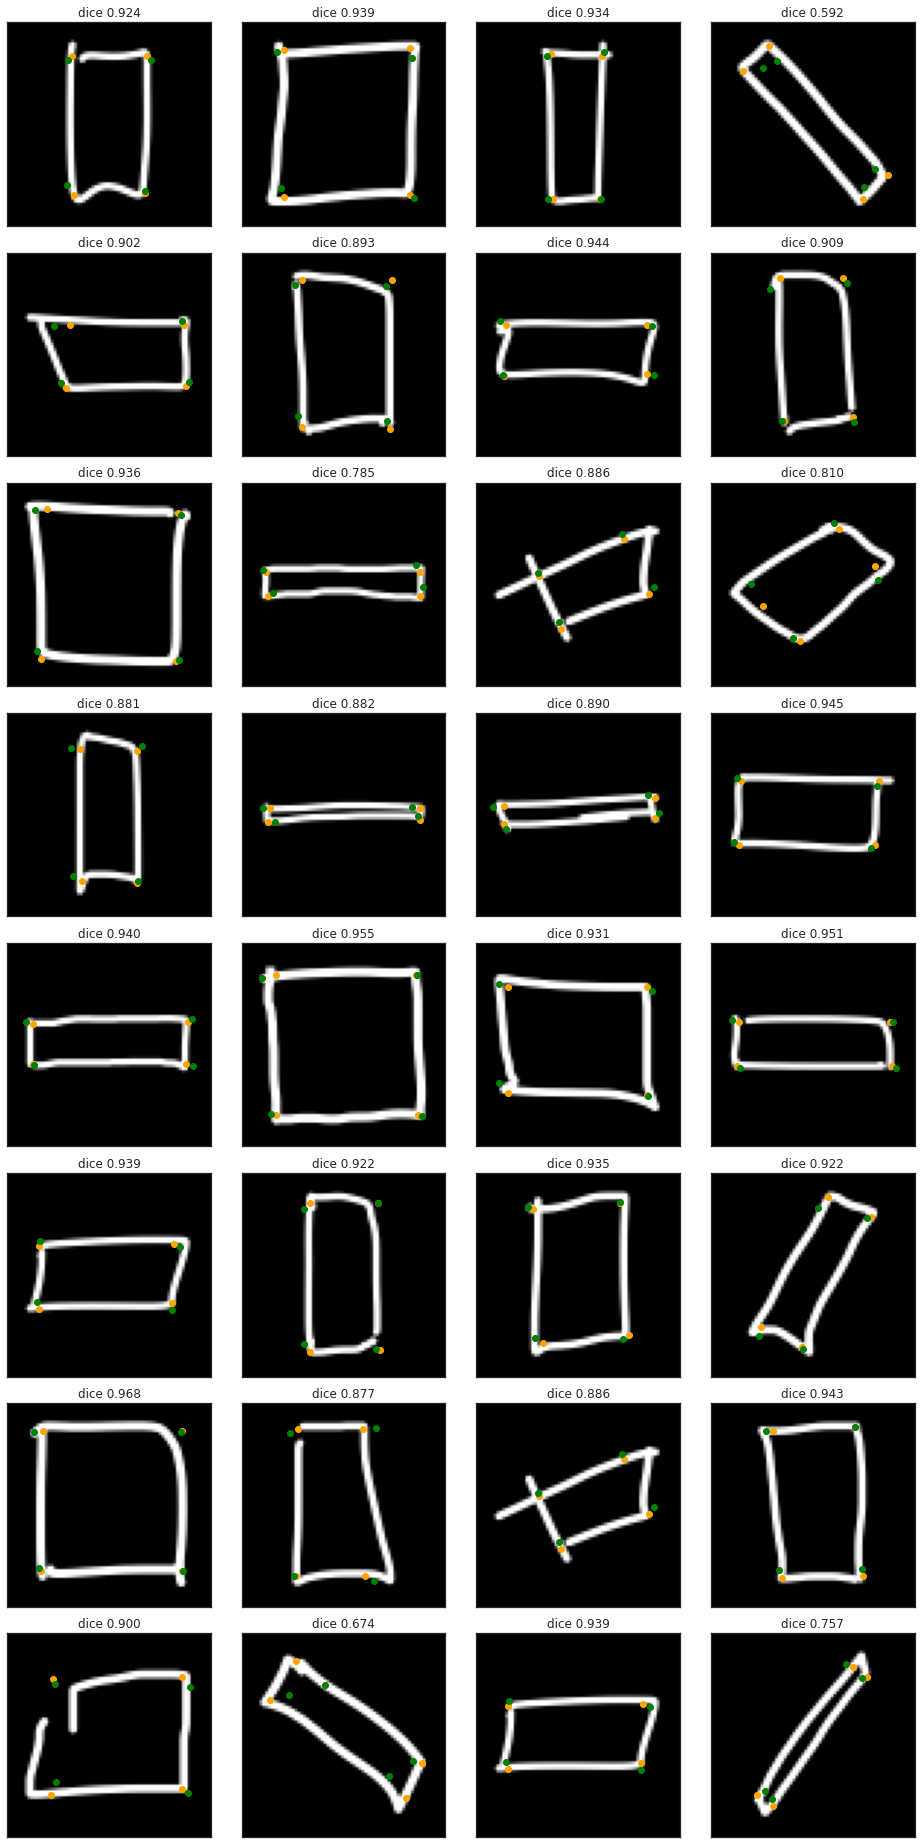

In [ ]:
fig = plt.figure(figsize=(13, 21))
fig.subplots_adjust(hspace=0.13, wspace=0.01,
                    left=0, right=1, bottom=0, top=1.2)
nb_pictures = 32
count = 1
for irow in range(nb_pictures):
    ipic = np.random.choice(X_val.shape[0])
    ax = fig.add_subplot(nb_pictures//4 , 4, count,xticks=[],yticks=[])        
    plot_sample_with_pred(X_val[ipic], Y_val[ipic], Y_val_pred[ipic], ax)
    try:
        dice = calculate_Dice(Y_val[ipic], Y_val_pred[ipic], nb_vertices=nb_vertices)
        ax.set_title("dice {:5.3f}".format(dice))
    except Exception as e:
        print(f"Cannot compute Dice for shape: {i}.")         
    count += 1
plt.show()

In [ ]:
## Prepare the Test set
test_X = test_data
test_y = test_labels
print("test_X shape: ", test_X.shape)
print("test_y shape: ", test_y.shape)

X_test    = test_X.reshape(-1, image_size,image_size, 1)
Y_test    = test_y 
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

test_X shape:  (179, 70, 70)
test_y shape:  (179, 8)
X_test shape:  (179, 70, 70, 1)
Y_test shape:  (179, 8)


In [ ]:
test_loss = model.evaluate(X_test, Y_test)
print("test_loss: ", test_loss)

6/6 [==============================] - 1s 44ms/step - loss: 7.1316e-04
test_loss:  0.0007131581078283489


In [ ]:
Y_test_pred = model.predict(X_test)

6/6 [==============================] - 0s 5ms/step


In [ ]:
print("Y_pred shape: ", Y_test_pred.shape)
Y_test_pred[0:2, :]

Y_pred shape:  (179, 8)


array([[0.29944113, 0.6966918 , 0.31134814, 0.20040727, 0.70764965,
        0.27504012, 0.6657971 , 0.7738451 ],
       [0.10502362, 0.6368683 , 0.10913065, 0.27236134, 0.8705072 ,
        0.31183386, 0.86946535, 0.71076524]], dtype=float32)

In [ ]:
dice_val = calculate_Dice_for_set(Y_test, Y_test_pred, nb_vertices)
print(f"Validation Accuracy(Dice): {dice_val}.")

Validation Accuracy(Dice): 0.9228658797332846.


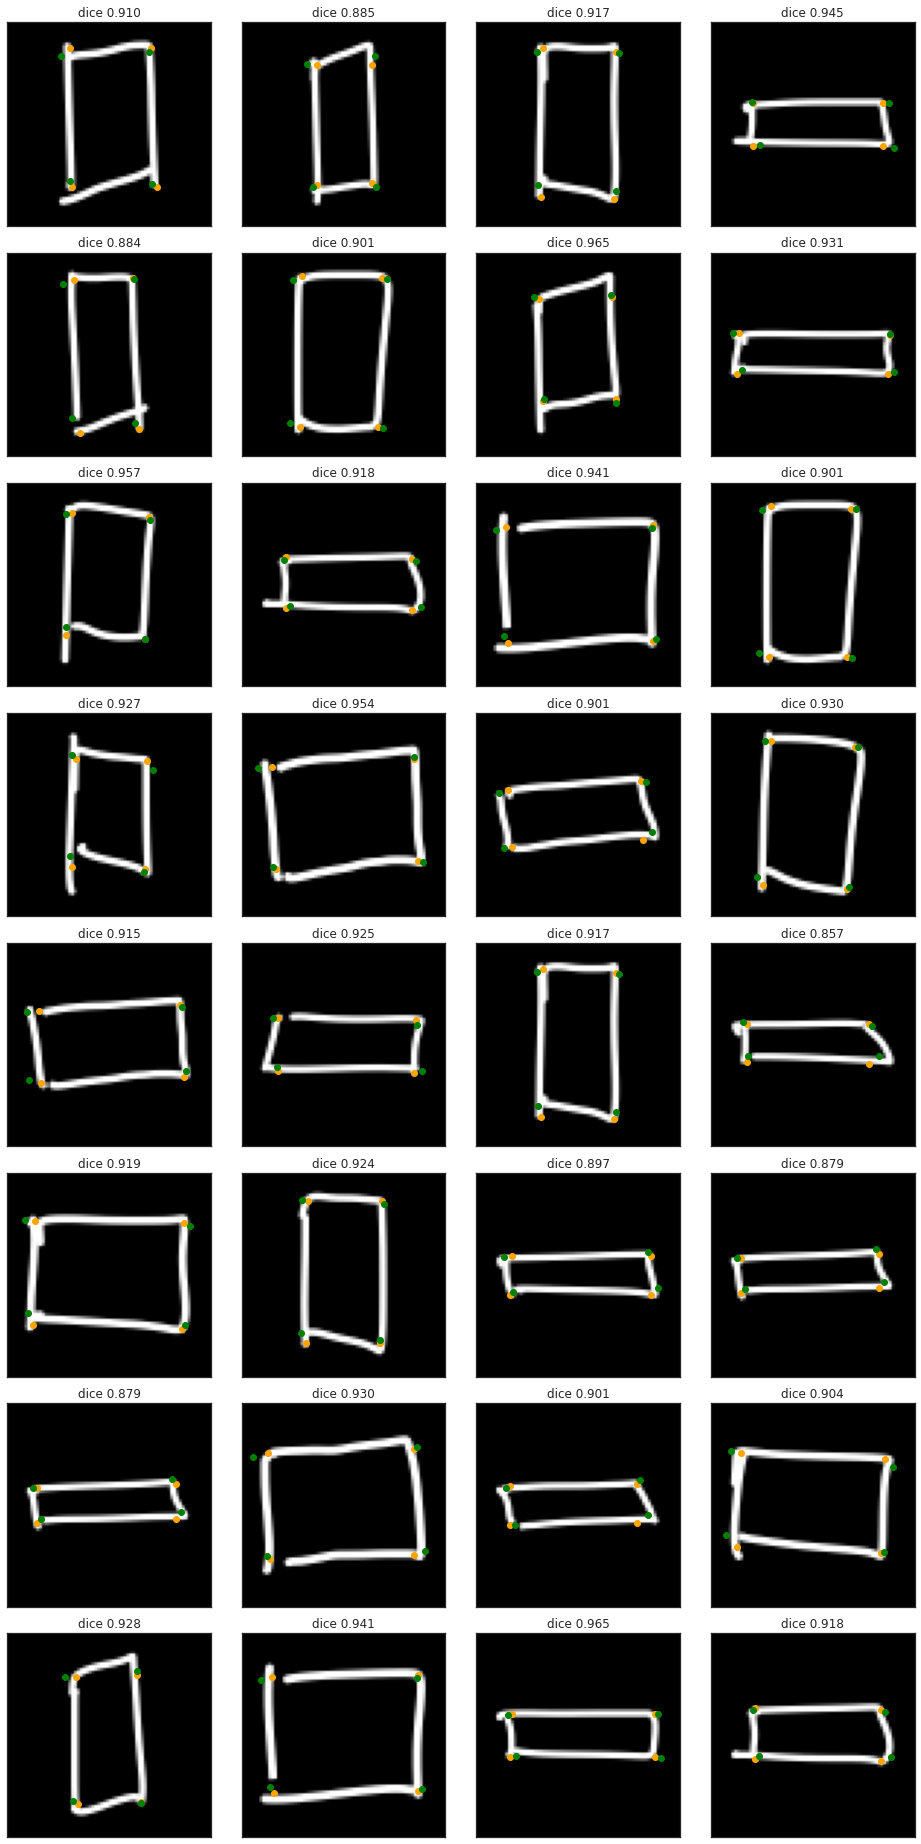

In [ ]:
fig = plt.figure(figsize=(13, 21))
fig.subplots_adjust(hspace=0.13, wspace=0.01,
                    left=0, right=1, bottom=0, top=1.2)
nb_pictures = 32
count = 1
for irow in range(nb_pictures):
    ipic = np.random.choice(X_test.shape[0])
    ax = fig.add_subplot(nb_pictures//4 , 4, count,xticks=[],yticks=[])        
    plot_sample_with_pred(X_test[ipic], Y_test[ipic], Y_test_pred[ipic], ax)
    
    try:
        dice = calculate_Dice(Y_test[ipic], Y_test_pred[ipic], nb_vertices=nb_vertices)
        ax.set_title("dice {:5.3f}".format(dice))
    except Exception as e:
        print(f"Cannot compute Dice for shape: {i}.")    
        
    count += 1
plt.show()

# **let's put the two models to use**

In [ ]:
model1 = load_model("/content/model/my_model.h5")

In [ ]:
model2 = load_model("/content/working/saved_models/my_rectangle1.model.h5")

In [ ]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

canvas_html = """
<canvas id=myCanvas width=%d height=%d ></canvas>
<button>Finish</button>
<style>#myCanvas { background-color: white; }</style>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=700, h=700, line_width=1):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  aaaaa =cv2.imread(filename,-1)
  print(aaaaa.shape)
  aaq=cv2.resize(aaaaa, (70,70))
  x=prepare(filename)
  plt.imshow(aaq)
  plt.axis("off")
  plt.show()
  aaq = aaq[:,:,3]
  im = aaq.reshape(-1,70,70,1)/255
  pred = model1.predict([im])
  shape_name = output_labels[pred.argmax()]
  if shape_name =='rectangle' :
    ax = model2.predict([im])
    image = np.zeros(shape=(700,700,3))
    arr=  ax[0]
    arr = arr*700
    arr = np.array([int(i) for i in arr])
    window_name = 'Output'
    # Start coordinate, here (0, 0)
    # represents the top left corner of image
    start_point = (arr[0],arr[1])
      
    # End coordinate, here (250, 250)
    # represents the bottom right corner of image
    end_point = (arr[2], arr[3])
      
    # white color in RGB
    color = (255, 255, 255)
      
    # Line thickness of 9 px
    thickness = 20
      
    # Using cv2.line() method
    # Draw a diagonal green line with thickness of 9 px
    image = cv2.line(image, start_point, end_point, color, thickness)

    start_point = (arr[2],arr[3])
    end_point = (arr[4], arr[5])
    image = cv2.line(image, start_point, end_point, color, thickness)

    start_point = (arr[4],arr[5])
    end_point = (arr[6], arr[7])
    image = cv2.line(image, start_point, end_point, color, thickness)

    start_point = (arr[6],arr[7])
    end_point = (arr[0], arr[1])
    image = cv2.line(image, start_point, end_point, color, thickness)

    # Displaying the image 
    plt.imshow(1-image/255)
    plt.axis("off")
    plt.show()
    return shape_name ,ax[0]
  return shape_name,None

(700, 700, 4)


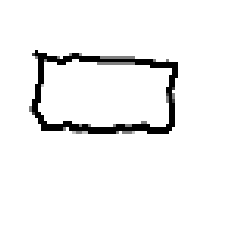

1/1 [==============================] - 0s 21ms/step


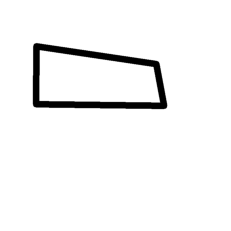

'rectangle'

In [ ]:
n,arr = draw(line_width=20)

n